In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(0)

Xtrain = np.load("housing_train_features.npy")
Xtest = np.load("housing_test_features.npy")
ytrain = np.load("housing_train_labels.npy")
ytest = np.load("housing_test_labels.npy")

feature_names = np.load("housing_feature_names.npy", allow_pickle=True)
print("First feature name: ", feature_names[0])
print("Lot frontage for first train sample:", Xtrain[0,0])

First feature name:  Lot.Frontage
Lot frontage for first train sample: 141.0


In [2]:
def normalize(x):
    u = np.mean(x, axis = 1).reshape(-1, 1)
    #u = np.tile(u, (1, x.shape[1]))

    var = np.var(x, axis = 1).reshape(-1, 1)
    norm_x = (x - u)/ var**0.5

    return norm_x, u, var

In [3]:
Xtrain_norm, u, var = normalize(Xtrain)
# since the numerical issues, the values are very close to 0
rounded_mean_values = np.round(np.mean(Xtrain_norm, axis = 1), decimals=10)
print(np.mean(Xtrain_norm, axis = 1))
print(np.var(Xtrain_norm, axis = 1))

[-2.06945572e-16 -4.97379915e-17 -7.88702437e-16  7.46069873e-17
  9.76996262e-18  3.55271368e-18 -1.17239551e-16  2.80664381e-16
 -1.08002496e-15 -4.41602310e-15 -2.27373675e-16  1.35003120e-16
  4.97379915e-17  1.50990331e-17 -5.50670620e-17 -1.06581410e-17
  1.20792265e-16 -4.61852778e-17 -7.81597009e-17 -1.58095759e-16
  1.06581410e-16 -3.55271368e-18  1.03028697e-16 -1.27897692e-16
 -1.42108547e-17 -1.06581410e-17  3.19744231e-17  6.03961325e-17
  3.90798505e-17 -2.06057393e-16 -1.66977543e-16  2.04281037e-17
 -4.51194637e-16  8.17124146e-17  1.84741111e-16  1.63424829e-16
  6.92779167e-17  3.55271368e-18 -1.59872116e-16  2.66453526e-17
  3.55271368e-17 -6.03961325e-17  8.34887715e-17 -5.50670620e-17
 -1.31450406e-16  1.06581410e-17  1.59872116e-17 -6.21724894e-18
  0.00000000e+00 -3.90798505e-17  1.24344979e-17  3.73034936e-17
 -2.66453526e-17  5.68434189e-17 -2.75690581e-14 -7.46069873e-17
 -5.32907052e-17 -1.77635684e-18]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1

In [4]:
print(Xtrain.shape)

(58, 2000)


Text(0.5, 1.0, 'Standard Deviation')

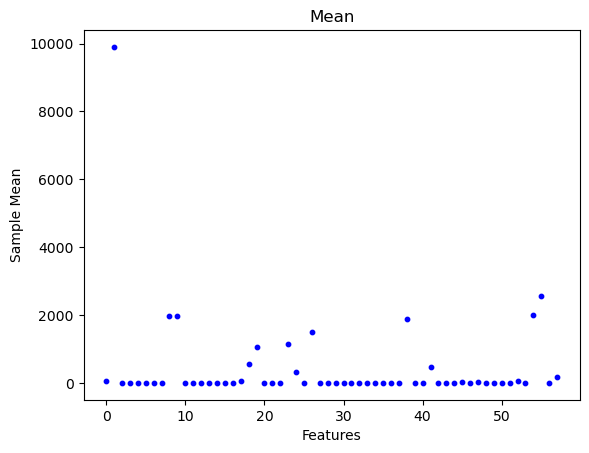

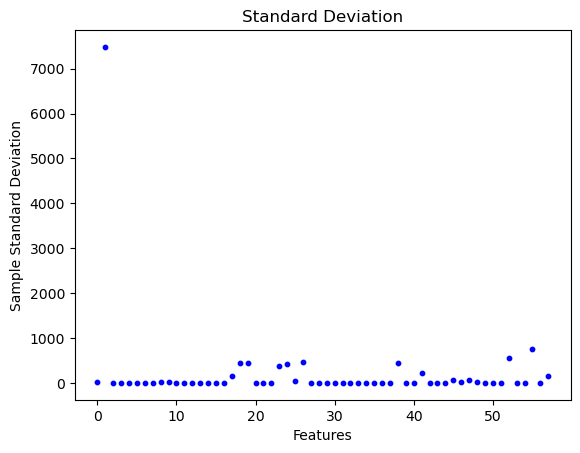

In [5]:
plt.figure(1)
plt.scatter(range(Xtrain.shape[0]), u[:, 0], marker='o', linestyle='-', color='b', s=10)
plt.xlabel("Features")
plt.ylabel("Sample Mean")
plt.title("Mean")

plt.figure(2)
plt.scatter(range(Xtrain.shape[0]), var[:, 0]**(0.5), marker='o', linestyle='-', color='b', s=10)
plt.xlabel("Features")
plt.ylabel("Sample Standard Deviation")
plt.title("Standard Deviation")

In [6]:
def soft_threshold(c, lam, a):
    if c < -lam:
        return (c + lam) / a
    elif c > lam:
        return (c - lam) / a
    else:
        return 0
def CD_Lasso(x, y, lam = 100 / 2000):
    iterations = int(2900 / x.shape[0])
    w = np.ones((x.shape[0], 1)) # d * 1 = 58 * 1

    for i in range(iterations):
     # x is d * n
        for j in range(x.shape[0]):
            x0 = x[j].reshape(-1, 1) # n * 1

            x1 = np.delete(x, j, 0) # d-1 * n
            w1 = np.delete(w, j).reshape(-1, 1) # d-1 * 1
            y_pred = (np.transpose(x1).dot(w1)) # n * 1  
            #y_pred = np.dot(np.transpose(x1) - np.mean(y), w1)          
            #print(y_pred.shape)
            y = y.reshape(-1, 1)
            c = (2 * np.dot(x0.T, (y - y_pred - np.mean(y)))) / x.shape[1]
            #c = (2 * np.dot(x0.T, (y - y_pred))) / x.shape[1]
            #print(c)
            a = (2 * np.sum(np.power(x0, 2))) / x.shape[1]

            w[j, :] = soft_threshold(c, lam, a)
    return w

In [7]:
w_optimal = CD_Lasso(Xtrain_norm, ytrain)


In [8]:
# Compute test MSE
# normalize Xtest by the mean and std calculate on Xtrain
Xtest_norm = (Xtest - u) / var**0.5
#print(Xtest_norm.shape)
y_pred = np.transpose(Xtest_norm).dot(w_optimal) + np.mean(ytrain)
y_pred = y_pred.reshape(-1)
test_mse = np.mean(np.power(ytest - y_pred, 2))
print("Test MSE:", test_mse)

Test MSE: 755.0824383673374


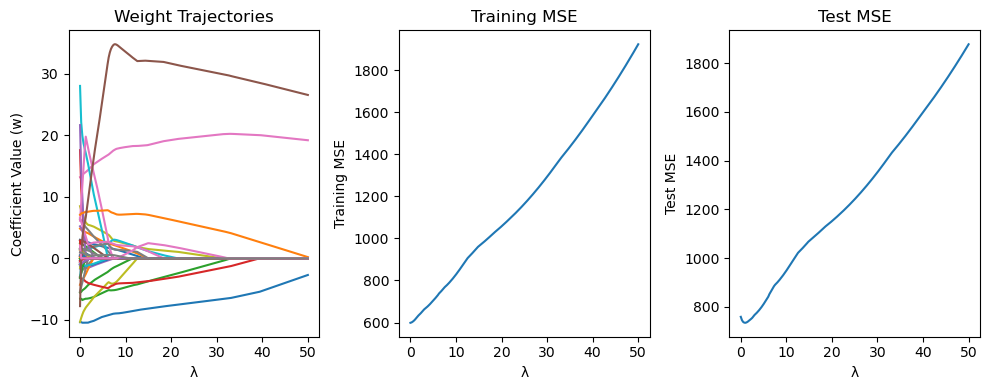

λ that minimizes training error: 0.0
λ that minimizes test error: 1.0050251256281406


In [9]:
num_samples = 200
lambda_values = np.linspace(0, 1e5 / Xtrain.shape[1], num_samples)

trajectory_w = np.zeros((num_samples, Xtrain.shape[0]))
train_mse_all = np.zeros(num_samples)
test_mse_all = np.zeros(num_samples)

for i, lambda_ in enumerate(lambda_values):
    
    w = CD_Lasso(Xtrain_norm, ytrain, lambda_)
    w = w.reshape(-1)
    # Store the coefficients (ignoring the offset b)
    #print(w)
    trajectory_w[i, :] = w
    
    y_pred1 = np.transpose(Xtrain_norm).dot(trajectory_w[i, :])
    train_mse_all[i] = np.mean((ytrain - y_pred1- np.mean(ytrain))**2)
    
    y_pred2 = np.transpose(Xtest_norm).dot(trajectory_w[i, :])
    test_mse_all[i] = np.mean((ytest - y_pred2 - np.mean(ytrain))**2)
    
    


#print(train_mse_all) 
plt.figure(figsize=(10, 4))

# Weight trajectories plot
plt.subplot(1, 3, 1)
for i in range(Xtrain.shape[0]):
    plt.plot(lambda_values, trajectory_w[:, i], label=f'w_{i+1}')
plt.xlabel('λ')
plt.ylabel('Coefficient Value (w)')
#plt.legend()
plt.title('Weight Trajectories')

# Training MSE plot
plt.subplot(1, 3, 2)
plt.plot(lambda_values, train_mse_all)
plt.xlabel('λ')
plt.ylabel('Training MSE')
plt.title('Training MSE')

# Test MSE plot
plt.subplot(1, 3, 3)
plt.plot(lambda_values, test_mse_all)
plt.xlabel('λ')
plt.ylabel('Test MSE')
plt.title('Test MSE')

plt.tight_layout()
plt.show()

# Find the λ that minimizes training error and test error
best_lambda_train = lambda_values[np.argmin(train_mse_all)]
best_lambda_test = lambda_values[np.argmin(test_mse_all)]

print(f"λ that minimizes training error: {best_lambda_train}")
print(f"λ that minimizes test error: {best_lambda_test}")